# Introduction

This notebook shows what Neural Network Training looks like under the hood.

Backpropagation is at the mathematical core of any modern Deep Neural Network Library.

In [58]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Visualization Graph for Mathematical Expressions

In [59]:
# Visual Graph for Expressions

from graphviz import Digraph

def trace(root):

  # builds the nodes and edges in the graph

  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)

  return nodes, edges

def draw_dot(root):

  dot = Digraph(format='svg', graph_attr= {'rankdir': 'LR'}) # LR = Left to Right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # build rectangular node for a value in graph
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,  n.grad), shape = 'record')

    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
      dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


# Value Class

It is the building block of the neural network. Value onject is defined to store the scalar value, children data, label, gradient and backpropagation logic for each data item. It also implements back propagation algorithm and automatic differentiation.

In [60]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return Value(self.data * -1)

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): #self/other
    return self * (other**-1)

  def __pow__(self, other):
    assert isinstance(other,(int, float)), "only supports int/float powers"
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh()')
    def _backward():
      self.grad += (1 - t**2) * out.grad # derivative of tanh multiplied by out.grad because it's a part of the chain of nodes
                                        #(follows chain rule for derivation operation)
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = [] # build topological graph
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1 # set grad for the node to 1
    for node in reversed(topo): # call _backward in reverse order of nodes
      node._backward()

# Single Neuron Functionality

In [61]:
# build a neuron and update Value class to facilitate tanh() activation function

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

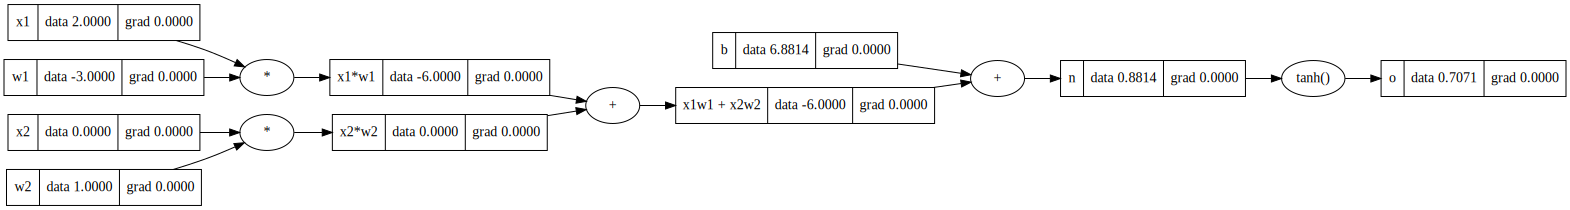

In [62]:
draw_dot(o)

# Update The Gradients

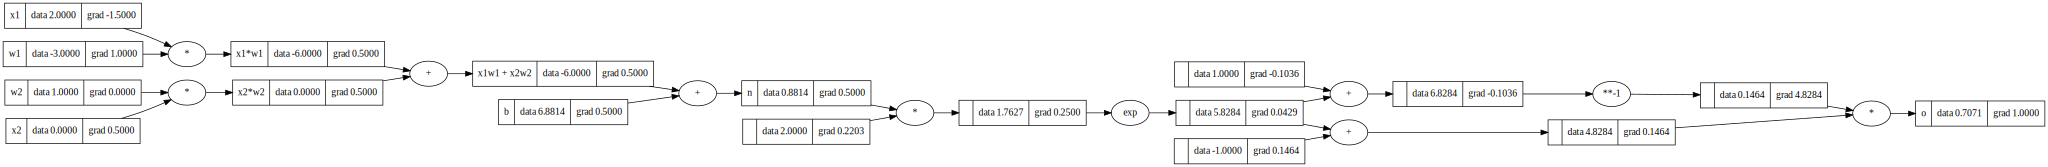

In [63]:
# replace tanh with it's exponential form

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp() # e ^ 2n
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

# Define The Neuron, Layer and MLP Class

In [64]:
# define Neuron class

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout): # nin is no. of input neurons, nout is no. of neurons in the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()] # single list comprehension

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [65]:
x = [5.0, 9.0, 11.0]
n = Neuron(3)
n(x)

Value(data=0.9999999995965609)

In [66]:
x = [5.0, 9.0, 11.0]
n = Layer(3, 5)
n(x)

[Value(data=-0.9605330781125172),
 Value(data=-0.9999999998577552),
 Value(data=0.999968631980438),
 Value(data=0.9999999999969129),
 Value(data=0.7911319276805704)]

In [67]:
x = [5.0, 9.0, 11.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6536038676452345)

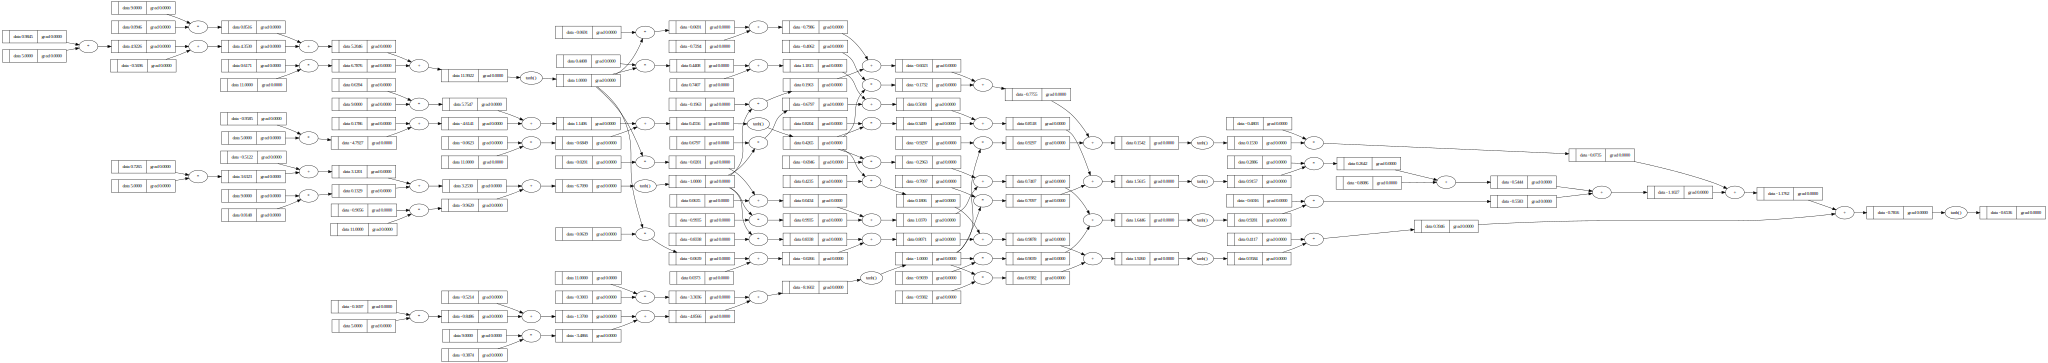

In [68]:
draw_dot(n(x))

In [69]:
# Creating a tiny dataset

xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
] # inputs

ys = [1, -1, -1, 1] # dersired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.22728201841992843),
 Value(data=-0.7855188951225294),
 Value(data=-0.6371246074627709),
 Value(data=-0.37098410163228795)]

# Gradient Descent

In [70]:
# Define Loss Function - Squared Loss and
# Implement Gradient Descent

for k in range(100):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start = Value(0))

  # backward pass
  for p in n.parameters(): # This is important to stop gradient accumulation
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.2 * p.grad

  print(f'Iteration: {k+1}, Loss Value: {loss.data}')

Iteration: 1, Loss Value: 3.5634992545238937
Iteration: 2, Loss Value: 7.670265602801846
Iteration: 3, Loss Value: 6.818769659941172
Iteration: 4, Loss Value: 2.383929717888542
Iteration: 5, Loss Value: 6.136376644530211
Iteration: 6, Loss Value: 2.568659277861281
Iteration: 7, Loss Value: 0.19493321222102322
Iteration: 8, Loss Value: 0.04400493508580401
Iteration: 9, Loss Value: 0.03336544764024042
Iteration: 10, Loss Value: 0.027321931731758717
Iteration: 11, Loss Value: 0.02328846548725758
Iteration: 12, Loss Value: 0.020356932075800888
Iteration: 13, Loss Value: 0.018109971451414315
Iteration: 14, Loss Value: 0.016323600415014197
Iteration: 15, Loss Value: 0.01486474419691124
Iteration: 16, Loss Value: 0.013648448632511852
Iteration: 17, Loss Value: 0.012617502920447662
Iteration: 18, Loss Value: 0.01173175536659871
Iteration: 19, Loss Value: 0.010962084225564746
Iteration: 20, Loss Value: 0.010286792517988216
Iteration: 21, Loss Value: 0.009689348988378612
Iteration: 22, Loss Valu

# Final Prediction

In [71]:
ypred

[Value(data=0.9782808435807432),
 Value(data=-0.9967610449643446),
 Value(data=-0.9728874052666139),
 Value(data=0.9788394208157991)]